# Моделирование Монте-Карло с помощью Python

<a href="https://t.me/init_python"><img src="https://dfedorov.spb.ru/pandas/logo-telegram.png" width="35" height="35" alt="telegram" align="left"></a>

<a href="https://colab.research.google.com/github/dm-fedorov/pandas_basic/blob/master/быстрое%20введение%20в%20pandas/Моделирование%20Монте-Карло%20с%20помощью%20Python.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory" target="_blank"></a>

## Введение

Существует множество моделей, которые могут использоваться для решения задачи прогнозирования. Одним из подходов, который может дать лучшее понимание диапазона возможных результатов и помочь избежать ["ошибки средних"](https://hbr.org/2002/11/the-flaw-of-averages), является [*моделирование методом Монте-Карло*](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9C%D0%BE%D0%BD%D1%82%D0%B5-%D0%9A%D0%B0%D1%80%D0%BB%D0%BE). 

В оставшейся части этой статьи будет описано, как использовать *Python* с *pandas* и *NumPy* для прогнозирования диапазона потенциальных значений для бюджета комиссионных с продаж с помощью моделирования Монте-Карло. 

> Оригинал статьи Криса [тут](https://pbpython.com/monte-carlo.html)

## Проблема

В следующем примере попытаемся предсказать, сколько денег необходимо выделить на комиссионные с продаж (поощрительные выплаты) в следующем году. Эта задача хорошо подходит для моделирования, т.к. у нас есть определенная формула для расчета комиссионных, и некоторый опыт с выплатой комиссионных за предыдущие годы.

Эта проблема также важна с точки зрения бизнеса. Комиссионные с продаж могут оказаться большими расходами, и важно их правильно спланировать. Кроме того, использование моделирования Монте-Карло является относительно простым.

Примерная комиссия с продаж будет выглядеть следующим образом для отдела продаж из `5` человек:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_1.png?raw=True)

В этом примере комиссия рассчитывается по следующей формуле:

`Commission Amount (Сумма комиссии) = Actual Sales (Фактические продажи) * Commission Rate (Ставка комиссионного вознаграждения)`

Ставка комиссии основана на этой таблице `Percent To Plan (Процент к плану)`:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_4.png?raw=True)

Прежде чем строить модель и запускать симуляцию, давайте рассмотрим простой подход к прогнозированию комиссионных расходов на следующий год.

## Наивный подход к проблеме

Представьте, что ваша задача в роли аналитика Эми или Энди состоит в том, чтобы сообщить финансовому отделу, сколько в бюджете необходимо выделить комиссионных с продаж на следующий год. Один из подходов заключается в том, чтобы предположить, что каждый выполняет `100%` своей цели и получает `4%` комиссионных. 

Вставка этих значений в *Excel* дает следующее:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_2.png?raw=True)

Представьте, что вы представляете это финансовому отделу, и они говорят: "У нас никогда не бывает одинаковых комиссионных. Нам нужна более точная модель". 

Во втором раунде вы можете попробовать несколько диапазонов:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_5.png?raw=True)

Или еще один:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Excel_Table_6.png?raw=True)

Теперь у вас есть немного больше информации. На этот раз финансовый отдел говорит: "Этот диапазон полезен, но каково ваше доверие к нему? Кроме того, нам нужно, чтобы вы провели расчет для отдела продаж из 500 человек и смоделировали несколько различных ставок, чтобы определить сумму бюджета". Хммм… 

Этот простой подход иллюстрирует основной итерационный метод моделирования Монте-Карло. Вы повторяете процесс много раз, чтобы определить диапазон возможных значений комиссионных за год. Сделать это вручную сложно. К счастью, с Python процесс значительно упрощается.

## Монте-Карло

Теперь, когда мы обсудили проблему на высоком уровне, посмотрим, как метод Монте-Карло может быть применим для прогнозирования комиссионных расходов на следующий год. На простейшем уровне анализ (или моделирование) Монте-Карло выполняет множество сценариев с различными случайными входными данными и обобщение распределения результатов.

Используя анализ комиссионных, мы можем продолжить ручной процесс, который мы начали выше, но запустить программу `100` или даже `1000` раз, и получим распределение потенциальных сумм комиссии. Это распределение может информировать о вероятности того, что расходы будут в пределах определенного окна. В конце концов, это прогноз, поэтому мы, скорее всего, никогда его точно не предскажем. Мы можем разработать более информативное представление о потенциальном риске недостаточного или завышенного бюджета.

Запуск моделирования Монте-Карло состоит из двух компонентов:

- уравнение для оценки;
- случайные величины для входа.

Уравнение мы рассмотрели выше. Теперь нужно подумать о том, как заполнить случайные величины.

Один из простых подходов - взять случайное число от `0%` до `200%` (представляющее нашу интуицию о ставках комиссионных). Однако, поскольку мы выплачиваем комиссионные каждый год, мы понимаем нашу проблему немного подробнее и можем использовать эти предварительные знания для построения более точной модели.

Поскольку мы выплачивали комиссионные в течение нескольких лет, мы можем взглянуть на типичное историческое распределение целевого процента:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/monte_carlo_image_hist_pct.png?raw=True)

Это распределение выглядит как нормальное распределение со средним значением `100%` и стандартным отклонением `10%`. Это понимание полезно, потому что мы можем моделировать наше распределение входных переменных так, чтобы оно было похоже на реальный опыт.

Если вас интересуют дополнительные детали для оценки типа распределения, я рекомендую [эту статью](https://www.mikulskibartosz.name/monte-carlo-simulation-in-python/).

## Построение модели Python

Можем использовать *pandas* для построения модели, которая воспроизводит расчет таблицы *Excel*. Существуют и другие подходы к построению моделей Монте-Карло, но я считаю, что с помощью *pandas* легче понять, если вы ранее работали с *Excel*. 

Выполним импорт и установим стиль для графиков:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

Для этой модели мы будем использовать генерацию случайных чисел из *NumPy*. Преимущество *NumPy* заключается в том, что существует [несколько генераторов случайных чисел](https://numpy.org/doc/stable/reference/random/index.html), которые могут создавать случайные выборки на основе заранее заданного распределения.

Как сказано выше, мы знаем, что исторический процент к целевой производительности сосредоточен вокруг среднего значения `100%` и стандартного отклонения `10%`. Давайте определим эти переменные, а также количество торговых представителей и число симуляций, которое мы моделируем:

In [ ]:
avg = 1
std_dev = .1
num_reps = 500
num_simulations = 1000

Теперь мы можем использовать *NumPy* для создания списка процентов, который будет воспроизводить историческое нормальное распределение:

In [ ]:
pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

В этом примере я решил округлить результат до двух знаков после запятой, чтобы было легче увидеть границы. 

Вот как выглядят первые `10` пунктов:

In [ ]:
pct_to_target[:10]

array([0.96, 1.14, 0.99, 0.98, 1.17, 1.02, 1.12, 0.84, 0.83, 0.92])

Это хорошая проверка, чтобы убедиться, что диапазоны соответствуют ожиданиям.

Поскольку мы пытаемся улучшить наш простой подход, то будем придерживаться нормального распределения целевого процента. Однако, используя *NumPy*, можно настроить и использовать другое распределение для будущих моделей, если это необходимо. Предупреждаю, что не надо использовать другие модели, не понимая их и, как они применимы к вашей ситуации.

Есть еще одно значение, которое нужно смоделировать, и это фактическая цель продаж. Чтобы проиллюстрировать другое распределение, предположим, что наше целевое распределение продаж выглядит примерно так:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/monte_carlo_sales_target.png?raw=True)

Это определенно ненормальное распределение. Это распределение показывает нам, что цели продаж устанавливаются в `1` из `5` сегментов, и частота уменьшается с увеличением суммы. Такое распределение может свидетельствовать об очень простом процессе установления целевых показателей, при котором отдельные лица делятся на определенные группы и получают целевые показатели последовательно в зависимости от их срока пребывания (tenure), размера территории или воронки продаж.

Для этого примера будем использовать равномерное распределение, но назначим более низкие уровни вероятности для некоторых значений.

Вот как мы можем это построить, используя [`numpy.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html):

In [ ]:
sales_target_values = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)

In [ ]:
sum(sales_target_prob)

1.0

По общему признанию, это несколько надуманный пример, но я хотел показать, как различные распределения могут быть включены в модель. 

Теперь, когда мы знаем, как создать два входных распределения, давайте создадим фрейм данных (*dataframe*) *pandas*:

In [ ]:
df = pd.DataFrame(index=range(num_reps), 
                  data={'Pct_To_Target': pct_to_target,
                        'Sales_Target': sales_target})

In [ ]:
df

,Pct_To_Target,Sales_Target
0,0.96,75000
1,1.14,75000
2,0.99,75000
3,0.98,500000
4,1.17,75000
...,...,...
495,1.14,75000
496,0.91,200000
497,1.29,100000
498,1.17,100000


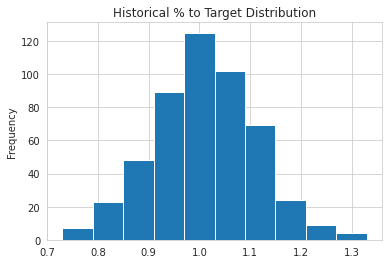

In [ ]:
# Простая гистограмма для подтверждения распределения
df['Pct_To_Target'].plot(kind='hist', title='Historical % to Target Distribution');

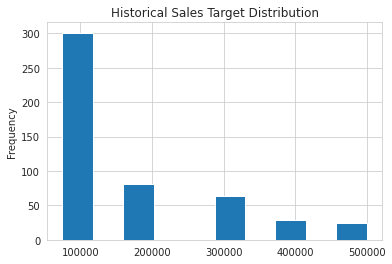

In [ ]:
# Посмотрите на целевое распределение продаж
df['Sales_Target'].plot(kind='hist', 
                        title='Historical Sales Target Distribution');

In [ ]:
# Фактическая сумма продаж
df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

Вот как выглядит новый фрейм данных:

In [ ]:
df.head()

,Pct_To_Target,Sales_Target,Sales
0,0.96,75000,72000.0
1,1.14,75000,85500.0
2,0.99,75000,74250.0
3,0.98,500000,490000.0
4,1.17,75000,87750.0


Вы могли заметить, что я проделал небольшой трюк, чтобы вычислить фактическую сумму продаж (*actual sales amount*). Для этой задачи фактическая сумма продаж может сильно меняться с годами, но распределение производительности остается удивительно стабильным. Поэтому я использую случайные распределения для генерации исходных данных и поддержки фактических продаж.

Последний фрагмент кода, который нужно создать, - это способ вычисления на основании `Pct_To_Target` ставки комиссии. 

Вот функция:

In [ ]:
def calc_commission_rate(x):
    """ Вернуть комиссию по таблице:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

> Дополнительное преимущество использования *Python* вместо *Excel* заключается в том, что мы можем создать гораздо более сложную логику, которую легче понять, чем если бы мы пытались создать сложный вложенный оператор *if* в *Excel*.

Теперь мы создаем ставку комиссии и умножаем ее на продажи:

In [ ]:
df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)

In [ ]:
# Рассчитайте комиссии
df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

Результат похож на модель, построенную в *Excel*:

In [ ]:
df.head()

,Pct_To_Target,Sales_Target,Sales,Commission_Rate,Commission_Amount
0,0.96,75000,72000.0,0.03,2160.0
1,1.14,75000,85500.0,0.04,3420.0
2,0.99,75000,74250.0,0.03,2227.5
3,0.98,500000,490000.0,0.03,14700.0
4,1.17,75000,87750.0,0.04,3510.0


Просуммируем значения в каждом из столбцов (нужный нам результат в столбце `Commission_Amount`):

In [ ]:
df['Sales'].sum(), df['Commission_Amount'].sum(), df['Sales_Target'].sum()

(87058000.0, 3027895.0, 86175000)

Вот и все!

Мы воспроизвели модель, аналогичную той, что сделали в *Excel*, но использовали несколько более сложных распределений, чем просто добавление в задачу набора случайных чисел.

## Запустим цикл

Настоящая "магия" моделирования Монте-Карло заключается в том, что, если мы запускаем моделирование много раз, то начинаем формировать картину вероятного распределения результатов. В *Excel* понадобится *VBA* для выполнения нескольких итераций. В *Python* мы можем использовать `цикл for` для запуска любого количества симуляций.

Помимо запуска каждой симуляции, сохраняем результаты, которые нам интересны, в списке, который превратим во фрейм данных для дальнейшего анализа распределения результатов.

Вот полный код цикла:

In [ ]:
# Определите список, чтобы сохранить результаты каждой симуляции, которую хотим проанализировать
all_stats = []

# Пройдите через множество симуляций
for i in range(num_simulations):

    # Выберите случайные входные данные для целей продаж и процент для целей
    sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

    # Создайте фрейм данных на основе входных значений и количества повторений
    df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                                   'Sales_Target': sales_target})

    # Вернитесь к количеству продаж, используя процент для целевой ставки
    df['Sales'] = df['Pct_To_Target'] * df['Sales_Target']

    # Определите ставку комиссии и рассчитайте ее
    df['Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)
    df['Commission_Amount'] = df['Commission_Rate'] * df['Sales']

    # Мы хотим отслеживать продажи, суммы комиссионных и целевые показатели продаж по всем симуляциям
    all_stats.append([df['Sales'].sum().round(0),
                      df['Commission_Amount'].sum().round(0),
                      df['Sales_Target'].sum().round(0)])

Результаты `1 миллиона` симуляций не всегда более полезны, чем `10 000`. Попробуйте разное количества и посмотрите, как изменится результат.

Чтобы проанализировать результаты моделирования, я построю фрейм данных из `all_stats`:

In [ ]:
results_df = pd.DataFrame.from_records(all_stats, columns=['Sales',
                                                           'Commission_Amount',
                                                           'Sales_Target'])

In [ ]:
results_df

,Sales,Commission_Amount,Sales_Target
0,88160000.0,3053635.0,87425000
1,79275000.0,2716790.0,78925000
2,84729750.0,2930335.0,84325000
3,83809000.0,2875735.0,83275000
4,81747500.0,2733195.0,82350000
...,...,...,...
995,86340000.0,2910118.0,86650000
996,84327500.0,2916530.0,83775000
997,85031500.0,2907348.0,84900000
998,82147750.0,2777318.0,82325000


Теперь легко увидеть, как выглядит диапазон результатов:

In [ ]:
results_df.describe().style.format('{:,}')

,Sales,Commission_Amount,Sales_Target
count,"1,000.0","1,000.0","1,000.0"
mean,"83,676,486.0","2,856,455.914","83,677,475.0"
std,"2,600,751.9583146865","97,379.18074585214","2,595,960.517878765"
min,"75,420,250.0","2,583,680.0","75,575,000.0"
25%,"81,891,687.5","2,789,401.5","81,850,000.0"
50%,"83,689,500.0","2,855,613.0","83,700,000.0"
75%,"85,450,750.0","2,926,000.25","85,381,250.0"
max,"92,264,750.0","3,224,112.0","92,075,000.0"


Графически это выглядит так:

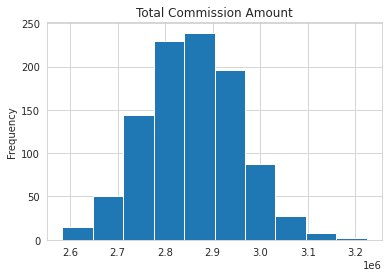

In [ ]:
results_df['Commission_Amount'].plot(kind='hist', 
                                     title="Total Commission Amount");

Итак, о чем говорит эта диаграмма и результат описания? 

Видим, что средние комиссионные расходы составляют `2,85 миллиона долларов`, а стандартное отклонение составляет `103 тысячи долларов`. Мы также видим, что размер комиссионных может составлять от `2,5` до `3,2 млн долларов`.

Исходя из этих результатов, насколько вы уверены, что расходы на комиссионные будут меньше `3 миллионов долларов`? Или, если кто-то скажет: "Давайте выделим только `2,7 миллиона долларов`", почувствуете ли вы, что ваши расходы будут меньше этой суммы? Возможно нет.

В этом заключается одно из преимуществ моделирования Монте-Карло. Вы лучше понимаете распределение вероятных результатов и можете использовать эти знания, а также свою деловую хватку, чтобы сделать обоснованную оценку.

Другая ценность этой модели состоит в том, что вы можете моделировать множество различных предположений и смотреть, что происходит. Вот несколько простых изменений, которые вы можете внести, чтобы увидеть, как меняются результаты:

- увеличить максимальную комиссию до 5%;
- уменьшите количество продавцов;
- измените ожидаемое стандартное отклонение на большее значение;
- изменить распределение целей.

Теперь, когда модель создана, внести эти изменения так же просто, как настроить несколько переменных и повторно запустить код. 

Еще одно наблюдение, касающееся моделирования методом Монте-Карло, заключается в том, что его относительно легко объяснить конечному пользователю. Человек, получающий эту оценку, может не иметь глубоких математических знаний, но способен интуитивно понять, что делает это моделирование и как оценить вероятность диапазона возможных результатов.

Наконец, я думаю, что показанный здесь подход легче понять и воспроизвести, чем некоторые решения *Excel*, с которыми вы можете столкнуться. 

## Заключение

*Моделирование методом Монте-Карло* - полезный инструмент для прогнозирования будущих результатов путем многократного вычисления формулы с различными случайными входными данными. 

Дополнительным преимуществом *Python* является то, что аналитики могут запускать множество сценариев, изменяя исходные данные, и переходить к гораздо более сложным моделям в будущем, если возникнут потребности. Наконец, результатами можно поделиться с нетехническими пользователями и облегчить обсуждение неопределенности конечных результатов.

### Обновления 19 марта 2019 г. 
> Основываясь на [комментариях Reddit](https://www.reddit.com/r/Python/comments/arxwkm/monte_carlo_simulation_with_python/), я сделал еще одну [реализацию](https://colab.research.google.com/github/chris1610/pbpython/blob/master/notebooks/Monte_Carlo_Simulationv2.ipynb), которая работает быстрее. См. ниже

<a href="https://t.me/init_python"><img src="https://dfedorov.spb.ru/pandas/logo-telegram.png" width="35" height="35" alt="telegram" align="left"></a>

### Monte Carlo Simulation with Python II

Notebook to accompany article on [Practical Business Python](https://pbpython.com/monte-carlo.html)

Update to use numpy for faster loops based on comments [here](https://www.reddit.com/r/Python/comments/arxwkm/monte_carlo_simulation_with_python/)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')

In [ ]:
# Define the variables for the Percent to target based on historical results
avg = 1
std_dev = .1
num_reps = 500
num_simulations = 100000

In [ ]:
# Show an example of calculating the percent to target
pct_to_target = np.random.normal(
    avg,
    std_dev,
    size=(num_reps, num_simulations)
)

In [ ]:
pct_to_target[0:10]

array([[0.9997651 , 1.09994229, 1.05178416, ..., 0.99340482, 0.90188913,
        0.93783077],
       [0.95528656, 1.07620953, 0.80324495, ..., 1.07895963, 0.98580228,
        0.80715527],
       [0.9509499 , 1.04047365, 1.13367182, ..., 1.08312434, 0.90090913,
        1.23517809],
       ...,
       [0.8689671 , 0.8715995 , 0.89249232, ..., 0.96423141, 0.9505922 ,
        0.96143733],
       [0.80264301, 1.12098251, 0.87688543, ..., 1.09888677, 0.90133742,
        0.86946373],
       [1.04021928, 0.98600112, 0.96411866, ..., 0.85341598, 0.96192711,
        1.0615466 ]])

In [ ]:
# Another example for the sales target distribution
sales_target_values = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
sales_target = np.random.choice(sales_target_values, p=sales_target_prob, 
                                size=(num_reps, num_simulations))

In [ ]:
sales_target[0:10]

array([[200000,  75000, 300000, ..., 500000, 200000, 300000],
       [100000, 200000,  75000, ..., 300000,  75000,  75000],
       [200000, 100000, 200000, ...,  75000, 100000, 200000],
       ...,
       [100000, 300000, 100000, ...,  75000, 100000, 100000],
       [100000, 200000,  75000, ...,  75000, 300000, 300000],
       [ 75000, 500000,  75000, ...,  75000, 100000, 200000]])

In [ ]:
commission_percentages = np.take(
    np.array([0.02, 0.03, 0.04]),
    np.digitize(pct_to_target, bins=[.9, .99, 10])
)

In [ ]:
commission_percentages[0:10]

array([[0.04, 0.04, 0.04, ..., 0.04, 0.03, 0.03],
       [0.03, 0.04, 0.02, ..., 0.04, 0.03, 0.02],
       [0.03, 0.04, 0.04, ..., 0.04, 0.03, 0.04],
       ...,
       [0.02, 0.02, 0.02, ..., 0.03, 0.03, 0.03],
       [0.02, 0.04, 0.02, ..., 0.04, 0.03, 0.02],
       [0.04, 0.03, 0.03, ..., 0.02, 0.03, 0.04]])

In [ ]:
total_commissions = (commission_percentages * sales_target).sum(axis=0)

In [ ]:
total_commissions.std()

96260.29248781023

In [ ]:
# Show how to create the dataframe
df = pd.DataFrame(data={'Total_Commissions': total_commissions})
df.head()

,Total_Commissions
0,2817750.0
1,2770500.0
2,3008750.0
3,2963750.0
4,2833500.0


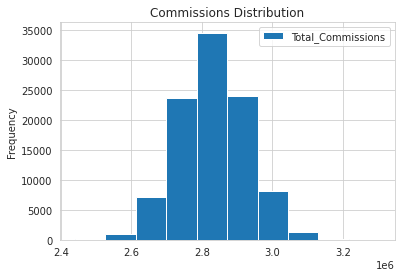

In [ ]:
df.plot(kind='hist', title='Commissions Distribution')

In [ ]:
df.describe()

,Total_Commissions
count,1.000000e+05
mean,2.831506e+06
std,9.626077e+04
min,2.439750e+06
25%,2.766000e+06
50%,2.830500e+06
75%,2.895562e+06
max,3.303750e+06


# Monte Carlo simulation in Python  “How to measure anything” Douglas W. Hubbard

https://www.mikulskibartosz.name/monte-carlo-simulation-in-python/

В книге «Как измерить что-либо» Дуглас У. Хаббард использует симуляцию Монте-Карло для решения следующей задачи:

Вы планируете арендовать машину для какого-то производственного процесса. Годовая аренда стоит вам 400 000 долларов, и вы не можете отменить досрочно. Вы задаетесь вопросом, достаточно ли высоки годовой уровень производства и экономия на техническом обслуживании, рабочей силе и сырье, чтобы оправдать аренду машины.

В этой статье мы собираемся реализовать симуляцию Монте-Карло на Python, чтобы решить проблему, описанную Д.В. Хаббард.

## Распределения вероятностей

В задаче, описанной в книге, все переменные распределены нормально. Что делать, если вы не знаете, каково распределение ваших переменных?

Я собираюсь использовать набор данных Титаника, чтобы показать вам некоторые распределения вероятностей:

In [24]:
RANDOM_STATE = 31415
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
dataset = seaborn.load_dataset('titanic')
# I want only the age column, but I don't want to deal with missing values
ages = dataset.age.dropna()

In [25]:
dataset

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


### Равномерное распределение

В простейшем случае все значения имеют одинаковую вероятность. Давайте создадим равномерное распределение значений от 0 до 20 и построим график функции плотности вероятности.

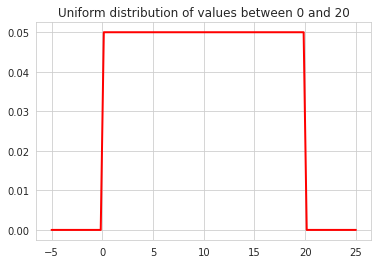

In [26]:
from scipy.stats import uniform
uniform_dist = uniform(loc = 0, scale = 20)
uniform_dist.rvs(size = 10, random_state = RANDOM_STATE)
x = np.linspace(-5, 25, 100)
_, ax = plt.subplots(1, 1)
ax.plot(x, uniform_dist.pdf(x), 'r-', lw = 2)
plt.title('Uniform distribution of values between 0 and 20')
plt.show()

### Распределение Бернулли

Распределение Бернулли используется, когда есть только два возможных исхода. Я загрузил набор данных Титаника, поэтому в следующем примере я собираюсь рассчитать вероятность выживания в аварии и построить ее график.

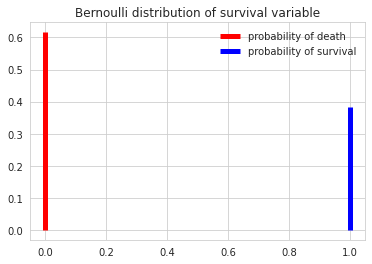

In [27]:
from scipy.stats import bernoulli
countSurvived = dataset[dataset.survived == 1].survived.count()
countAll = dataset.survived.count()
survived_dist = bernoulli(countSurvived / countAll)
# the given value is the probability of outcome 1 (survival) (let's call it p). # The probability of the opposite outcome (0 - death) is 1 - p.
_, ax = plt.subplots(1, 1)
ax.vlines(0, 0, survived_dist.pmf(0), colors='r', linestyles='-', lw=5, label="probability of death")
ax.vlines(1, 0, survived_dist.pmf(1), colors='b', linestyles='-', lw=5, label="probability of survival")
ax.legend(loc='best', frameon=False)
plt.title("Bernoulli distribution of survival variable")
plt.show()

### Дискретная случайная величина

Иногда у нас есть дискретная переменная, которая имеет более двух возможных состояний. В этом примере я буду использовать переменную pclass из набора данных Titanic:
(Обратите внимание, что только 1, 2 и 3 имеют вероятность выше 0. Других значений в данном наборе данных не существует. Следовательно, их вероятность равна 0:)

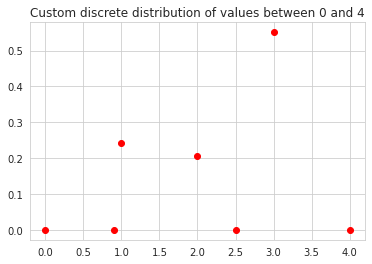

In [30]:
from scipy.stats import rv_discrete
pclass_probability = pd.DataFrame({'probability': dataset.groupby(by = "pclass").size() / dataset.pclass.count()}).reset_index()
values = pclass_probability.pclass
probabilities = pclass_probability.probability
custom_discrete_dist = rv_discrete(values=(values, probabilities))
x = [0, 0.9, 1, 2, 2.5, 3, 4]
_, ax = plt.subplots(1, 1)
ax.plot(x, custom_discrete_dist.pmf(x), 'ro', lw=2)
plt.title('Custom discrete distribution of values between 0 and 4')
plt.show()

### Нормальное распределение

Думаю, все знают, что сейчас будет ;)

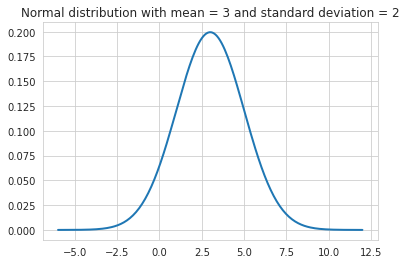

In [31]:
from scipy.stats import norm
mean = 3
st_dev = 2
normal_distribution = norm(loc = mean, scale = st_dev)
x = np.linspace(-6, 12, 200)
_, ax = plt.subplots(1, 1)
ax.plot(x, normal_distribution.pdf(x), '-', lw=2)
plt.title(f'Normal distribution with mean = {mean} and standard deviation = {st_dev}')
plt.show()

### Гамма-распределение

Гамма-распределение выглядит странно, но в некоторых случаях оно полезно. Например, я мог бы смоделировать поведение пользователя на типичном веб-сайте. Большинство пользователей собираются посетить одну страницу и уйти. Некоторые собираются щелкнуть другую ссылку и просмотреть еще немного. Лишь немногие из них будут продолжать нажимать и посещать более двух страниц. В этом случае я должен установить loc в 1, чтобы начать распределение в точке x = 1.

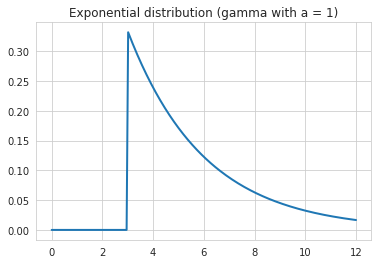

In [32]:
from scipy.stats import gamma
gamma_distribution = gamma(loc = 3, scale = 3, a = 1)
x = np.linspace(0, 12, 200)
_, ax = plt.subplots(1, 1)
ax.plot(x, gamma_distribution.pdf(x), '-', lw=2)
plt.title('Exponential distribution (gamma with a = 1)')
plt.show()

### Функция плотности вероятности или функция массы вероятности?

Я использую две разные функции для вычисления вероятностей. В чем разница между функцией плотности вероятности (PDF) и функцией массы вероятности (PMF)? Функция массы вероятности используется для вычисления вероятности дискретных значений. Функция плотности вероятности возвращает вероятность непрерывной случайной величины.

## Подгонка распределения к данным

Круто, мы можем определить некоторые распределения, но никто не будет угадывать значения параметров, чтобы получить распределение, соответствующее их данным. Итак, как мы можем сделать это автоматически?

К счастью, большинство реализаций распределения в scikit-learn имеют функцию «подгонки», которая получает данные в качестве параметра и возвращает параметры распределения.

Теперь пришло время подогнать распределение к столбцу возраста пассажиров «Титаника», отобразить гистограмму переменной возраста и построить график функции плотности вероятности распределения:

In [33]:
def fit_and_plot(dist):
    params = dist.fit(ages)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    x = np.linspace(0, 80, 80)
    _, ax = plt.subplots(1, 1)
    plt.hist(ages, bins = 80, range=(0, 80))
    ax2 = ax.twinx()
    ax2.plot(x, dist.pdf(x, loc=loc, scale=scale, *arg), '-', color = "r", lw=2)
    plt.show()
    return dist, loc, scale, arg

Давайте попробуем подогнать два распределения:

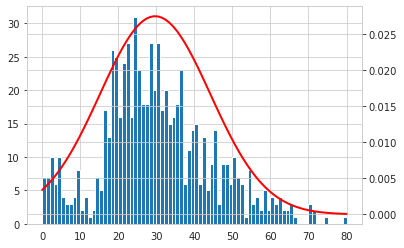

(<scipy.stats._continuous_distns.norm_gen at 0x7f2352239e50>,
 29.69911764705882,
 14.516321150817316,
 ())

In [35]:
fit_and_plot(norm)   

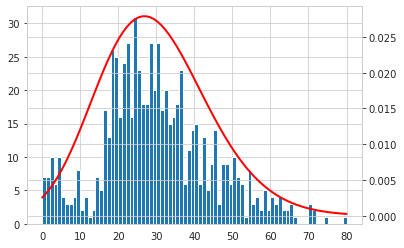

(<scipy.stats._continuous_distns.gamma_gen at 0x7f2351acf550>,
 -45.37307548137508,
 2.806622890786299,
 (26.748229688039117,))

In [36]:
fit_and_plot(gamma)

## Как выбрать лучшее распределение с помощью теста Колмогорова-Смирнова

Согласно определению, статистика Колмогорова – Смирнова количественно определяет расстояние между эмпирической функцией распределения выборки и кумулятивной функцией распределения эталонного распределения.

### Что это значит?
Это означает, что мы можем использовать этот тест, чтобы проверить, соответствует ли распределение вероятностей данным. Для этого необходимо указать уровень значимости. Обычно используется 0,05. Как и в любом статистическом тесте, если p-значение (вычисленное тестом) меньше уровня значимости, мы отклоняем нулевую гипотезу.

### Что такое гипотеза?
Нулевая гипотеза: данные соответствуют заданному распределению (нет разницы между обоими распределениями). Альтернативная гипотеза: хотя бы одно значение не соответствует указанному распределению (распределения различаются, я использую двусторонний тест, поэтому значения либо меньше, либо больше).

Я буду использовать ранее определенную функцию, чтобы подогнать нормальное распределение к заданному набору данных, а затем выполнить тест Колмогорова-Смирнова, чтобы проверить, соответствует ли оно распределению.

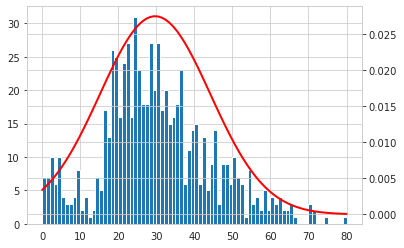

pvalue= 0.00496347192487969


In [55]:
from scipy.stats import kstest
dist, loс, scale, arg = fit_and_plot(norm)
d, pvalue = kstest(ages.tolist(), lambda x: dist.cdf(x, loc = loс, scale = scale, *arg), alternative="two-sided")
print('pvalue=',pvalue)

На диаграмме мы видим, что данные выглядят нормально распределенными, но существует огромная разница между фактическими значениями и нормальным распределением.

Это не тот сюжет, на который мы должны смотреть. Критерий Колмогорова-Смирнова вычисляет максимальную вертикальную разницу между эмпирическими кумулятивными распределениями. Построим кумулятивные распределения:

In [41]:
def fit_and_plot_cdf(dist):
    params = dist.fit(ages)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    x = np.linspace(0, 80, 80)
    _, ax = plt.subplots(1, 1)
    counts, bin_edges = np.histogram(ages, bins=80, normed=True)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf)
    ax2 = ax.twinx()
    ax2.plot(x, dist.cdf(x, loc=loc, scale=scale, *arg), '-', color = "r", lw=2)
    plt.show()
    return dist, loc, scale, arg

Результат выглядит следующим образом:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


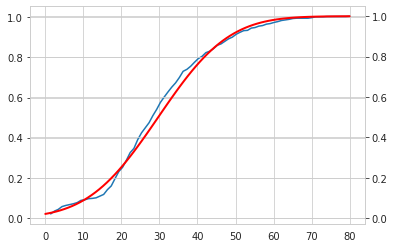

(<scipy.stats._continuous_distns.norm_gen at 0x7f2352239e50>,
 29.69911764705882,
 14.516321150817316,
 ())

In [49]:
fit_and_plot_cdf(norm)

Похоже, но немного странно. Как всегда, если p-значение низкое, нуль гипотеза должна уйти. Значение p равно 0,004, поэтому я должен отклонить нулевую гипотезу, поскольку данное нормальное распределение не соответствует данным.

Теперь я должен выбрать другое распределение вероятностей, подобрать его к данным и выполнить еще один тест, пока, наконец, не получу то, которое соответствует данным. Представьте, что я это сделал, и переходите к захватывающей части ;)

На всякий случай проверим происходит ли выборка из гамма-распределения

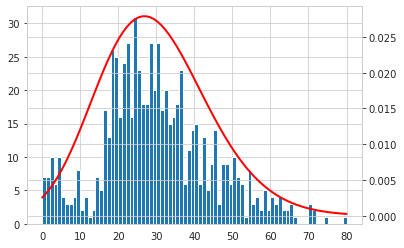

pvalue= 0.01722614936676394


In [54]:
from scipy.stats import kstest
dist, log, scale, arg = fit_and_plot(gamma)
d, pvalue = kstest(ages.tolist(), lambda x: dist.cdf(x, loc = log, scale = scale, *arg), alternative="two-sided")
print('pvalue=',pvalue)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


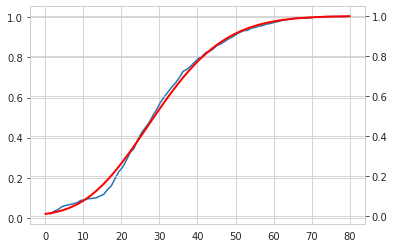

(<scipy.stats._continuous_distns.gamma_gen at 0x7f2351acf550>,
 -45.37307548137508,
 2.806622890786299,
 (26.748229688039117,))

In [50]:
fit_and_plot_cdf(gamma)

Значение p = 0,017 < 0,05, поэтому я должен отклонить нулевую гипотезу, поскольку данное нормальное распределение не соответствует данным.

# Моделирование Монте-Карло

Что такое моделирование Монте-Карло? Это процесс, который генерирует большое количество случайных сценариев на основе вероятности входных данных. Он вычисляет, что произойдет, когда ввод будет применен к тестовой функции. В конце концов, вероятность результатов показывает, какой исход наиболее вероятен.

Наконец, у нас есть все необходимое для моделирования чего-либо с помощью метода Монте-Карло. Я не могу подогнать какое-либо распределение к данным Дугласа У. Хаббарда, потому что он ими не делился, так что я должен доверять ему и просто использовать значение из книги.

Пример задачи из книги «Как измерить что угодно»: вы рассматриваете возможность аренды машины для какого-то производственного процесса. Годовая аренда стоит вам 400 000 долларов, и вы не можете отменить досрочно. Вы задаетесь вопросом, достаточно ли высоки годовой уровень производства и экономия на техническом обслуживании, рабочей силе и сырье, чтобы оправдать аренду машины.

От ваших экспертов-людей вы получили следующие диапазоны переменных (обратите внимание, что все диапазоны имеют доверительный интервал 90%, а значения распределены нормально):

    экономия на обслуживании: 10−20 долларов США за единицу

    экономия труда: -2–8 долларов США за единицу

    экономия сырья: 3−9 долларов США за единицу

    уровень производства: 15 000–35 000 единиц в год

    годовая аренда: $400000

    годовая экономия = (экономия на обслуживании + экономия труда + экономия сырья) * уровень производства

Что означают 90% доверительный интервал и нормальное распределение? 

Ваши эксперты говорят, что на 90% уверены, что значение будет где-то между нижней и верхней границей. Среднее значение — это среднее значение между верхней и нижней границей, поэтому в случае экономии на обслуживании среднее = 15 долларов. Стандартное отклонение определяется как (верхняя граница — нижняя граница) / 3,29. 3.29 стандартное отклонение, равное 90 % значений нормального распределения.

Что будем считать? Мы хотим знать, какова вероятность отказа (годовая экономия меньше стоимости машины).

In [43]:
_90_conf_interval = 3.29
maintenance = norm(loc = (20 + 10) / 2, scale = (20 - 10) / _90_conf_interval)
labor = norm(loc = (8 + -2) / 2, scale = (8 - -2) / _90_conf_interval)
raw_material = norm(loc = (9 + 3) / 2, scale = (9 - 3) / _90_conf_interval)
prod_level = norm(loc = (35000 + 15000) / 2, scale = (35000 - 15000) / _90_conf_interval)
number_of_simulations = 1000000
maintenance_results = maintenance.rvs(number_of_simulations)
labor_results = labor.rvs(number_of_simulations)
raw_materials_results = raw_material.rvs(number_of_simulations)
prod_level_results = prod_level.rvs(number_of_simulations)
data = pd.DataFrame({
    "maintenance_savings_per_unit": maintenance_results,
    "labor_savings_per_unit": labor_results,
    "raw_materials_savings_per_unit": raw_materials_results,
    "production_level": prod_level_results
})
data["total_savings"] = (data.maintenance_savings_per_unit + data.labor_savings_per_unit + data.raw_materials_savings_per_unit) * data.production_level

Кстати, вы видите ошибку? Я не устанавливал параметр random_state функции rvs, поэтому не могу воспроизвести свои результаты. Каждый раз, когда я запускаю код, я получаю другой результат!

Говоря о результате, мы можем построить его. Я добавил вертикальную линию на нашем пороге рентабельности:

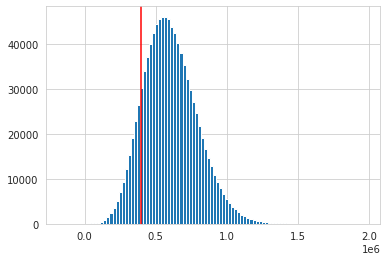

In [44]:
plt.hist(data.total_savings, bins = 100)
plt.axvline(x = 400000, c = "r")
plt.show()

Теперь мы можем подсчитать отказы: data[data["total_savings"] < 400000].count() и легко вычислить вероятность годовой экономии меньше стоимости машины (вероятность потери денег).

In [47]:
data[data["total_savings"] < 400000].count() # количество значений < 400000

maintenance_savings_per_unit      141393
labor_savings_per_unit            141393
raw_materials_savings_per_unit    141393
production_level                  141393
total_savings                     141393
dtype: int64

In [45]:
data[data["total_savings"] < 400000].count()["total_savings"] / 1000000

0.141393

В моем случае в результате я получил 0,140153. Следовательно, вероятность потери денег составляет около 14%.